In [47]:
# Accedo a Google Drive
from google.colab import drive
drive.mount(r'/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
# Importo librerías que vamos a usar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks # Nos va a servir para encontrar los máximos a la hora de graficar ;)
import statsmodels.api as sm # Nos va a servir para hacer la estimación de la Cobb Douglas

In [49]:
# Accedo a la PWT. En este caso, yo la tengo cargada en mi drive :)
file_path = '/content/drive/MyDrive/Colab Notebooks/economic-growth/pwt1001.xlsx' # Modificar el path según sea necesario
pwt = pd.read_excel(file_path, sheet_name="Data") # Poner el nombre de la hoja tal cual. Con esto armamos un dataframe

In [50]:
# Agrego como columnas las variables a calcular
pwt['S']=pwt['rdana']-pwt['rconna'] # Ahorro
pwt['Y per cápita']=pwt['rgdpna']/pwt['pop'] # PBI per cápita
pwt['Tasa de ahorro']=pwt['S']/pwt['rgdpna'] # Tasa de ahorro
pwt['Share de capital'] = 1 - pwt['labsh'] # Share de Capital
pwt['K per cápita']= pwt['rnna']/pwt['pop'] # Capital per cápita

# Tasas de crecimiento (calculadas como variaciones porcentuales, revisar)
pwt['n']= pwt['pop'].pct_change() * 100 # Tasa de crecimiento poblacional
pwt['Tasa de crecimiento de yt'] = pwt['Y per cápita'].pct_change() # Tasa de crecimiento del pbi per cápita
pwt['Tasa de crecimiento de kt'] = pwt['K per cápita'].pct_change() # Tasa de crecimiento del capital per cápita

# Residuo de Solow
pwt['PTF']= (pwt['Tasa de crecimiento de yt']) - (pwt['n'] * pwt['labsh']) - (pwt['Tasa de crecimiento de kt'] * pwt['Share de capital'])

# Función de producción agregada
pwt['fpa']= (pwt['K per cápita']/pwt['Y per cápita'])

# print(pwt) # Descomentar (sin dejar espacios!) para ver cómo quedó la pwt con los agregados

/tmp/ipython-input-713750640.py:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pwt['n']= pwt['pop'].pct_change() * 100 # Tasa de crecimiento poblacional
/tmp/ipython-input-713750640.py:10: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pwt['Tasa de crecimiento de yt'] = pwt['Y per cápita'].pct_change() # Tasa de crecimiento del pbi per cápita
/tmp/ipython-input-713750640.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' 

In [51]:
# Filtro Grecia (o el país que quiera) y armo un dataframe solo con sus datos
# La idea de poder seleccionar aquí el país con el que trabajaremos es facilitar la comparación con otros ejercicios sin tener que modificar todo el código
greece = pwt[pwt["country"] == "Greece"].copy()

In [52]:
pbireal = greece[["year", "rgdpna"]].dropna() # Defino como variable 'pbireal' el pbi a precios constantes (2017=1)
pbireal.set_index("year", inplace=True)
pbireal["variacion_pbi"] = pbireal["rgdpna"].pct_change().dropna()
pbireal["log_pbireal"] = np.log(pbireal["rgdpna"]) # La paso a logaritmo
peaks, _ = find_peaks(pbireal["log_pbireal"]) # Busco puntos máximos de la variación porcentual
peak_years = pbireal.index[peaks].tolist() # Armo un array con los peaks
peak_points = greece[greece['year'].isin(peak_years)] # Meto ese array dentro de un dataframe


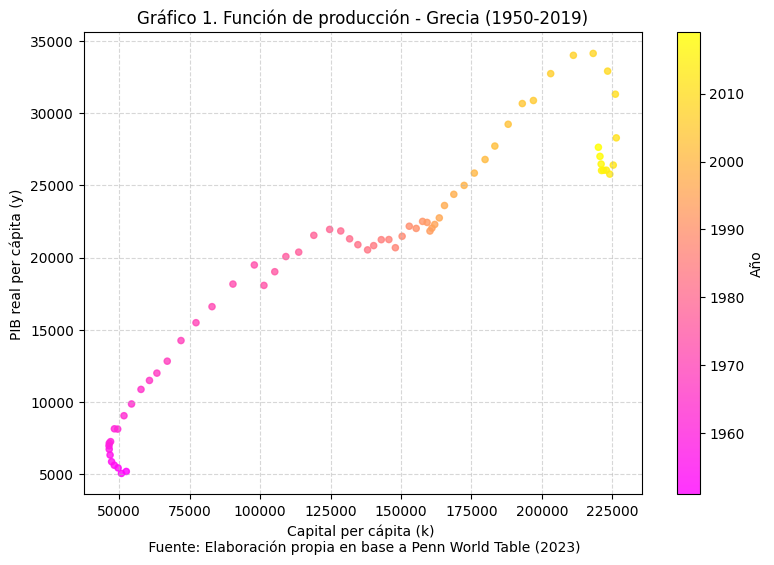

<Figure size 640x480 with 0 Axes>

In [53]:
# Gráfico de la función de producción
plt.figure(figsize=(9,6))

# Scatter principal
sc = plt.scatter(
    greece['K per cápita'],
    greece['Y per cápita'],
    c=greece['year'], cmap="spring", s=20, alpha=0.8
)

# Filtrar puntos de picos
#peak_points = greece[greece['year'].isin(peak_years)]

# Marcar peaks en rojo
#plt.scatter(
    #peak_points['K per cápita'],
    #peak_points['Y per cápita'],
    #c="red",
    #s=40,
    #marker="x",
    #label="Cambios de ciclo"
#)

# Etiquetar años de los peaks
#for _, row in peak_points.iterrows():
    #plt.text(row['K per cápita'], row['Y per cápita'], str(int(row['year'])),
             #fontsize=8, color="red")

plt.xlabel("Capital per cápita (k) \n Fuente: Elaboración propia en base a Penn World Table (2023)")
plt.ylabel("PIB real per cápita (y)")
plt.title("Gráfico 1. Función de producción - Grecia (1950-2019)")
plt.colorbar(sc, label="Año")
plt.grid(True, linestyle="--", alpha=0.5)
# plt.legend()
plt.show()

plt.savefig('Función de producción.png')

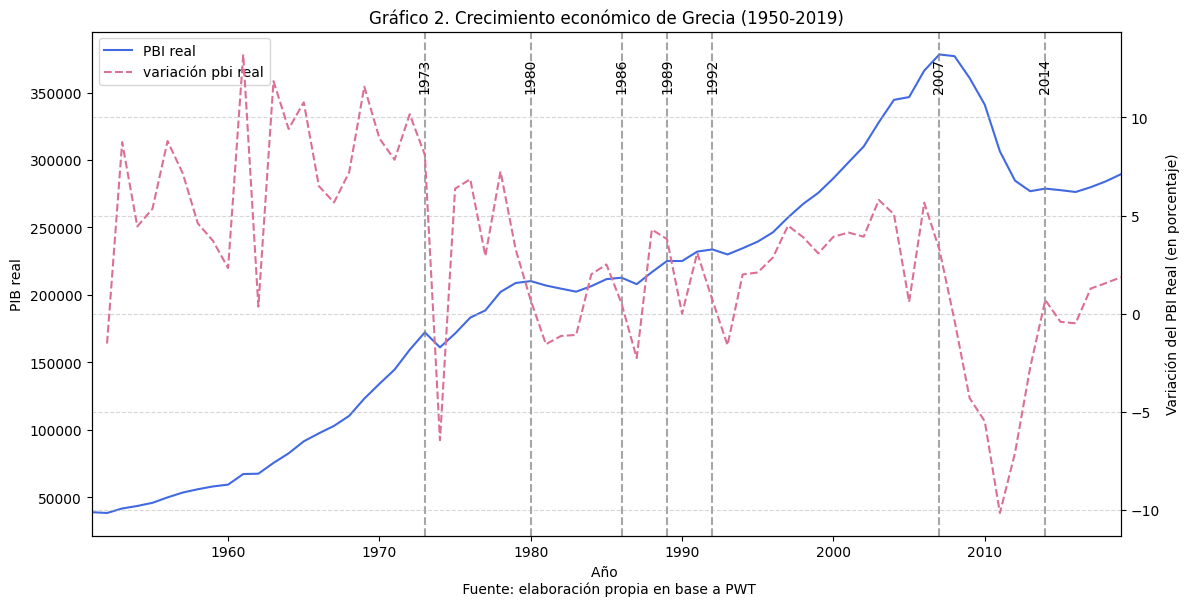

<Figure size 640x480 with 0 Axes>

In [54]:
# Gráfico de crecimiento del PBI
# import matplotlib.pyplot as plt (descomentar if needed)

fig, ax1 = plt.subplots(figsize=(12,6))

# PBI real en eje Y izquierdo
ax1.plot(pbireal.index, pbireal["rgdpna"], label="PBI real", color="royalblue")
ax1.set_xlabel("Año")
ax1.set_ylabel("PIB real", color="black") # El color puede ser modificado según necesario!
ax1.tick_params(axis="y", labelcolor="black")

# Eje Y derecho para log(PBI)
ax2 = ax1.twinx()
ax2.plot(pbireal.index, pbireal["variacion_pbi"]*100,
         label="variación pbi real", color="palevioletred", linestyle="--") # Color
ax2.set_ylabel("Variación del PBI Real (en porcentaje)", color="black")
ax2.tick_params(axis="y", labelcolor="black")

# Marcar picos en ambos ejes y mostrar el año
for peak_index in peaks:
    peak_year = pbireal.index[peak_index]
    ax1.axvline(x=peak_year, color="grey", linestyle="--", alpha=0.7)
    ax1.text(peak_year, ax1.get_ylim()[1] * 0.95, str(peak_year),
             rotation=90, verticalalignment='top', horizontalalignment='center', color='black')

# Título y referencia
plt.title("Gráfico 2. Crecimiento económico de Grecia (1950-2019)")
fig.tight_layout()
plt.grid(True, linestyle="--", alpha=0.5)
ax1.set_xlabel('Año \n Fuente: elaboración propia en base a PWT') # Para aclaraciones, referencias, etc.

# Cajas de referencia de los colores
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best') # Al elegir loc='best' el programa mismo va a evaluar dónde conviene poner la referencia
ax1.set_xlim(1951,2019)

plt.show() # Nos muestra cómo quedó el gráfico
plt.savefig('economic_growth_peaks.png') # Descargamos el gráfico lindo en png

In [55]:
# Análisis de los ciclos (excel)
peak_years = sorted(peak_years)  # aseguramos orden cronológico
start_year = greece['year'].min()
end_year = greece['year'].max()
boundaries = [start_year] + peak_years + [end_year]

ciclos = []
prev_start = start_year
for peak in peak_years:
    ciclos.append((prev_start, peak, f"{prev_start}-{peak}"))
    prev_start = peak + 1  # el siguiente ciclo empieza un año después del pico
ciclos.append((prev_start, end_year, f"{prev_start}-{end_year}"))  # último ciclo
def asignar_ciclo(year):
    for inicio, fin, nombre in ciclos:
        if inicio <= year <= fin:
            return nombre
    return None

# Armamos los ciclos
#ciclos = []
#for i in range(len(boundaries)-1):
 #   ciclo = f"{boundaries[i]}-{boundaries[i+1]}"
  #  ciclos.append((boundaries[i], boundaries[i+1], ciclo))
#def asignar_ciclo(year):
 #   for inicio, fin, nombre in ciclos:
  #      if inicio <= year <= fin:
   #         return nombre
    #return None

# Crear columna 'ciclo'
greece["ciclo"] = greece["year"].apply(asignar_ciclo)

# Calcular promedios y ciclo
greece_ciclos = (
    greece.groupby(["ciclo"])
    .mean(numeric_only=True)
    .reset_index()
)
print(greece_ciclos.head()) # Descomentar sin espacios para verificar que todo esté bien!



       ciclo    year          rgdpe          rgdpo        pop       emp  \
0  1950-1973  1961.5   60566.099864   61877.056301   8.254657  3.470065   
1  1974-1980  1977.0  132981.260045  137386.291295   9.263833  3.513014   
2  1981-1986  1983.5  147607.903646  151587.794271   9.879541  3.837054   
3  1987-1989  1988.0  167454.776042  170138.494792  10.104791  3.983776   
4  1990-1992  1991.0  191217.786458  190243.755208  10.320445  4.028517   

           avh        hc           ccon            cda  ...             S  \
0  2204.889457  1.915524   42192.343240   63314.625849  ...  30673.555537   
1  2108.038719  2.223978   93530.852679  143261.093750  ...  63755.235491   
2  2109.303655  2.368149  114278.580729  159609.679688  ...  52385.966146   
3  2108.876690  2.478975  130893.825521  178850.218750  ...  50298.098958   
4  2112.460916  2.554521  153977.322917  210105.994792  ...  56471.859375   

   Y per cápita  Tasa de ahorro  Share de capital   K per cápita          n  \
0   989

In [56]:
# Cuadro de valores segun ciclo, para analisis
# Mostramos los valores seleccionados por ciclo
variables = ['K per cápita', 'Tasa de crecimiento de kt', 'Y per cápita', 'Tasa de crecimiento de yt', 'PTF', 'n'] # Elijo la variable que vamos a utilizar

#greece_sel = greece[
#    (greece["ciclo"] )  # Filtro de ciclo, modificar segun necesario
#][["ciclo"] + variables]

# Pasar a formato cuadro (filas = país, columnas = quinquenio).
cuadro_ciclos = greece_ciclos.pivot_table(
    index=["ciclo"],
    values=variables
)

display(cuadro_ciclos)
cuadro_ciclos.to_excel("cuadro_ciclos.xlsx") # Guardamos en excel prolijo para copiar

,K per cápita,PTF,Tasa de crecimiento de kt,Tasa de crecimiento de yt,Y per cápita,n
ciclo,,,,,,
1950-1973,58915.602918,-9.990516,0.012029,0.026186,9898.416781,19.652833
1974-1980,114557.853369,-0.601188,0.039687,0.017379,20407.535456,1.225461
1981-1986,138954.557150,-0.337903,0.021003,-0.004436,21004.441716,0.661052
1987-1989,150465.920036,-0.221046,0.016289,0.014695,21440.932446,0.465813
1990-1992,157453.805730,-0.423197,0.013602,0.004021,22317.830376,0.860849
1993-2007,179014.643833,-0.194108,0.019030,0.028359,26654.914578,0.435568
2008-2014,223776.319275,0.254699,0.007837,-0.036719,29274.439830,-0.546929
2015-2019,220965.471547,0.245231,-0.002543,0.011941,26641.640016,-0.429787
